In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from typing import Counter
import imblearn
from imblearn.over_sampling import SMOTE

from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate
from functions_folder.nn_equalized_odds import equalised_odds
from functions_folder.nn_model_simplex import *
from functions_folder.short import *

In [2]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Data

In [2]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
hold_out_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure diastolic0,blood pressure diastolic1,blood pressure diastolic2,blood pressure diastolic3,blood pressure diastolic4,...,temperature14_current_stay_difference,temperature15_current_stay_difference,temperature16_current_stay_difference,temperature17_current_stay_difference,temperature18_current_stay_difference,temperature19_current_stay_difference,temperature20_current_stay_difference,temperature21_current_stay_difference,temperature_mean_current_stay_difference,temperature_std_current_stay_difference
14520,31658148.0,2154-01-11,1.0,1.0,0,0.320312,0.415623,0.454545,0.538462,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.000000
14521,31658148.0,2154-01-12,1.0,1.0,0,0.332031,0.295675,0.454545,0.538462,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.000000
14522,31658148.0,2154-01-13,1.0,1.0,0,0.520833,0.516462,0.272727,0.636364,0.0,...,0.6,-1.000000,0.600000,0.807636,-1.000000,-1.00000,0.064716,0.4,0.572265,0.480359
14523,33816676.0,2117-08-21,1.0,1.0,0,0.811198,0.823757,0.363636,0.291667,0.0,...,0.4,0.537778,0.885714,0.497132,-1.000000,-1.00000,0.489146,0.3,0.522223,0.453449
14524,33816676.0,2117-08-22,1.0,1.0,0,0.602865,0.610717,0.181818,0.333333,0.0,...,0.0,0.537778,0.600000,0.605099,-1.000000,-1.00000,0.800798,0.0,0.685277,0.849298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28818,37914144.0,2136-05-23,1.0,1.0,0,0.720052,0.675274,0.545455,0.411765,0.0,...,0.4,0.443395,0.171429,-1.000000,-1.000000,-1.00000,0.766030,0.4,0.559658,0.832024
28819,37246494.0,2127-07-17,1.0,1.0,0,0.082682,0.085539,0.181818,-1.000000,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.000000
28820,37246494.0,2127-07-18,1.0,1.0,0,0.213542,0.190445,0.363636,0.350000,0.0,...,0.4,0.521866,0.028571,0.537930,-1.000000,-1.00000,0.212624,0.4,0.761369,0.293540
28821,37246494.0,2127-07-19,1.0,1.0,0,0.296875,0.262750,0.272727,0.304348,0.0,...,0.4,0.521866,0.028571,0.537930,-1.000000,-1.00000,0.212624,0.4,0.761369,0.293540


In [4]:
mimic_data
mimic_data.stay_id.nunique()

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,blood pressure diastolic0,blood pressure diastolic1,blood pressure diastolic2,blood pressure diastolic3,...,temperature14_current_stay_difference,temperature15_current_stay_difference,temperature16_current_stay_difference,temperature17_current_stay_difference,temperature18_current_stay_difference,temperature19_current_stay_difference,temperature20_current_stay_difference,temperature21_current_stay_difference,temperature_mean_current_stay_difference,temperature_std_current_stay_difference
0,30000646.0,2194-04-29,1.0,NaN,0,0,0.421875,0.470626,0.454545,0.304348,...,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000
1,30000646.0,2194-04-30,1.0,NaN,0,1,0.596354,0.542931,0.909091,0.291667,...,0.4,0.824156,0.171429,-1.000000,-1.0,-1.0,0.531196,0.4,0.558757,0.244600
2,30000646.0,2194-05-01,1.0,NaN,0,2,0.622396,0.576501,0.363636,0.318182,...,0.8,0.561534,0.385714,0.674183,-1.0,-1.0,0.622217,0.4,0.728050,0.602105
3,30000646.0,2194-05-02,1.0,NaN,0,3,0.476563,0.486120,0.363636,0.291667,...,0.8,0.561534,0.385714,0.674183,-1.0,-1.0,0.622217,0.4,0.728050,0.602105
4,30000646.0,2194-05-03,1.0,1.0,0,4,0.438802,0.435119,0.272727,0.368421,...,0.2,0.561534,0.385714,0.674183,-1.0,-1.0,0.622217,0.1,0.410176,0.455833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28818,39996073.0,2175-09-14,NaN,1.0,1,1,0.941406,0.907682,0.363636,0.333333,...,0.4,0.650547,0.742857,0.484462,-1.0,-1.0,0.412870,0.8,0.548080,0.408792
28819,39996073.0,2175-09-15,NaN,1.0,1,999,0.989583,0.943189,0.454545,0.291667,...,0.4,0.650547,0.742857,0.484462,-1.0,-1.0,0.412870,0.8,0.548080,0.408792
28820,39996073.0,2175-09-16,NaN,1.0,1,999,0.980469,0.994190,0.363636,0.350000,...,0.4,0.710059,0.600000,0.484462,-1.0,-1.0,0.722340,0.4,0.842413,0.581162
28821,39996073.0,2175-09-17,NaN,1.0,1,999,0.980469,0.994190,0.272727,0.636364,...,0.4,0.710059,0.600000,0.484462,-1.0,-1.0,0.722340,0.4,0.842413,0.581162


8694

In [11]:
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]
hold_out_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure systolic17_current_stay,heart rate17,respiratory rate11_current_stay,blood pressure mean11_current_stay,o2 saturation pulseoxymetry3_current_stay,...,blood pressure systolic12_current_stay,o2 saturation pulseoxymetry1_current_stay_difference,gcs - verbal response14_current_stay,temperature7_current_stay,temperature6_current_stay_difference,respiratory rate3,heart rate21_current_stay,o2 saturation pulseoxymetry7_difference,gcs - verbal response2_difference,heart rate8
14520,31658148.0,2154-01-11,1.0,1.0,0,0.606696,-1.000000,0.836298,7.378308e-01,0.843672,...,0.000000,-1.000000,0.0,-1.000000e+00,-1.0,0.974359,0.111111,-1.000000,-1.0,0.076923
14521,31658148.0,2154-01-12,1.0,1.0,0,0.425485,0.626496,0.179521,3.985847e-01,0.505667,...,0.111111,-1.000000,0.0,0.000000e+00,-1.0,0.263889,0.333333,-1.000000,-1.0,0.000000
14522,31658148.0,2154-01-13,1.0,1.0,0,0.318146,0.626496,0.182053,3.735505e-01,0.463710,...,0.111111,0.028573,0.0,0.000000e+00,0.0,0.575758,0.333333,0.570812,-1.0,0.230769
14523,33816676.0,2117-08-21,1.0,1.0,0,0.252609,0.550296,0.255261,3.102556e-01,0.417992,...,0.000000,0.428570,0.0,5.525391e-01,0.4,0.263889,0.481481,0.880258,-1.0,0.153846
14524,33816676.0,2117-08-22,1.0,1.0,0,0.201628,0.577203,0.179738,4.681335e-01,0.396213,...,0.000000,0.428570,0.0,3.935210e-01,0.2,0.301587,0.481481,0.086525,-1.0,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28818,37914144.0,2136-05-23,1.0,1.0,0,0.301502,0.267609,0.230500,1.808925e-01,0.541103,...,0.000000,0.685716,0.0,4.478715e-29,0.8,0.703704,0.000000,0.522394,-1.0,0.615385
28819,37246494.0,2127-07-17,1.0,1.0,0,0.944596,-1.000000,0.761556,6.883370e-16,-1.000000,...,0.111111,-1.000000,-1.0,-1.000000e+00,-1.0,-1.000000,0.000000,-1.000000,-1.0,0.538462
28820,37246494.0,2127-07-18,1.0,1.0,0,0.584570,0.388734,0.295290,3.284427e-01,0.593548,...,0.111111,0.599999,0.0,8.846845e-30,1.0,0.575758,0.148148,0.263679,0.0,0.076923
28821,37246494.0,2127-07-19,1.0,1.0,0,0.317212,0.320100,0.241371,2.016687e-01,0.463710,...,0.444444,0.599999,0.0,5.687257e-30,1.0,0.263889,0.555556,0.263679,0.0,0.230769


In [12]:
individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

In [34]:
data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)

In [36]:
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

# Initializing the weights of our model.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Calculate the number of trainable parameters in the model.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

The model has 11,307 trainable parameters


Run

In [38]:
# Run short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = run_fun(data_dict, model, 'short')

100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


Test AUROC result: 0.8035941912307345
Test AUROC result 2: 0.8053819857403375


100%|██████████| 1/1 [00:00<00:00, 47.03it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


UPDATED BEST OVERALL MODEL


100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


Test AUROC result: 0.7920515013302927
Test AUROC result 2: 0.7830878626631192


100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Test AUROC result: 0.7824609502381893
Test AUROC result 2: 0.7852163890810775


100%|██████████| 1/1 [00:00<00:00, 226.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Test AUROC result: 0.7898335181129048
Test AUROC result 2: 0.7940158459749601


100%|██████████| 9/9 [00:01<00:00,  4.62it/s]


Test AUROC result: 0.7803364722860591
Test AUROC result 2: 0.7628670785910489


100%|██████████| 1/1 [00:00<00:00, 55.05it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


Test AUROC result: 0.7581538733447536
Test AUROC result 2: 0.7449288957772521


100%|██████████| 9/9 [00:01<00:00,  5.00it/s]


Test AUROC result: 0.7953653818484117
Test AUROC result 2: 0.7923478441591663


100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


Test AUROC result: 0.7802441675773301
Test AUROC result 2: 0.7786321860646311


100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


Test AUROC result: 0.7922311496881904
Test AUROC result 2: 0.7932477078568216


100%|██████████| 9/9 [00:01<00:00,  4.62it/s]


Test AUROC result: 0.746941601347412
Test AUROC result 2: 0.7369096974800803


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


In [39]:
analyze_results_fun(test_results)

mean test_auroc: 0.7776635493388494
std test_auroc: 0.02129079656784815
test_auroc 2.5th percentile: 0.738714017096944
test_auroc 97.5th percentile: 0.8028246042931276
mean test_accuracy: 0.7618358586077071
std test_accuracy: 0.014212762452179013
test_accuracy 2.5th percentile: 0.7407016628117375
test_accuracy 97.5th percentile: 0.7856757749924889
mean test_balanced_accuracy: 0.7776635493388494
std test_balanced_accuracy: 0.02129079656784814
test_balanced_accuracy 2.5th percentile: 0.738714017096944
test_balanced_accuracy 97.5th percentile: 0.8028246042931276
mean test_recall: 0.8019700708364432
std test_recall: 0.04949955424765467
test_recall 2.5th percentile: 0.7211393930799773
test_recall 97.5th percentile: 0.8667725988700565
mean test_precision: 0.39458119348742937
std test_precision: 0.022716002145420085
test_precision 2.5th percentile: 0.3571575126262626
test_precision 97.5th percentile: 0.42476569524514735
mean test_f1: 0.5286514336207032
std test_f1: 0.02863354157382322
test_f1

In [40]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.690244250633256
std test_auroc: 0.02663304220246492
test_auroc 2.5th percentile: 0.651908843859947
test_auroc 97.5th percentile: 0.7259104791028906
mean test_accuracy: 0.8311265042902279
std test_accuracy: 0.008329821046165876
test_accuracy 2.5th percentile: 0.814550111324591
test_accuracy 97.5th percentile: 0.8411601700950678
mean test_balanced_accuracy: 0.690244250633256
std test_balanced_accuracy: 0.026633042202464915
test_balanced_accuracy 2.5th percentile: 0.651908843859947
test_balanced_accuracy 97.5th percentile: 0.7259104791028905
mean test_recall: 0.4794631561301145
std test_recall: 0.06391514207841002
test_recall 2.5th percentile: 0.39335472206466254
test_recall 97.5th percentile: 0.560810853823506
mean test_precision: 0.49278462800235195
std test_precision: 0.030891492317696036
test_precision 2.5th percentile: 0.439939726398483
test_precision 97.5th percentile: 0.531264367816092
mean test_f1: 0.4843277277113853
std test_f1: 0.04184503846288417
test_f1 2.5t

In [41]:
# Save 
#with open("short_test_results", "wb") as fp:   #Pickling
#    pickle.dump(test_results, fp)
#with open("short_ub_test_results", "wb") as fp:   #Pickling
#    pickle.dump(ub_test_results, fp)

In [42]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
np.array(test_data_pr_ratio_list).mean()

0.16676326332462213

In [43]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.754702,0.740288,0.791667,0.286401
"(anchor_age, 30)",0.795622,0.795622,0.820714,0.229470
"(anchor_age, 40)",0.733541,0.733541,0.737650,0.270567
"(anchor_age, 50)",0.798357,0.798357,0.859963,0.263250
"(anchor_age, 60)",0.778860,0.778860,0.807334,0.249613
"(anchor_age, 70)",0.764794,0.764794,0.775438,0.245850
"(anchor_age, 80)",0.793720,0.793720,0.816183,0.228743
"(anchor_age, 90)",0.730798,0.730798,0.690040,0.228444
"(gender, F)",0.773965,0.773965,0.811374,0.263444
"(gender, M)",0.779664,0.779664,0.793251,0.233924


In [44]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.165676,0.183987,0.353553,0.127387
"(anchor_age, 30)",0.084011,0.084011,0.216404,0.061660
"(anchor_age, 40)",0.077915,0.077915,0.152637,0.055807
"(anchor_age, 50)",0.022545,0.022545,0.057069,0.042392
"(anchor_age, 60)",0.040197,0.040197,0.075028,0.028957
"(anchor_age, 70)",0.037692,0.037692,0.091316,0.038975
"(anchor_age, 80)",0.020968,0.020968,0.042572,0.036237
"(anchor_age, 90)",0.076838,0.076838,0.194330,0.070876
"(gender, F)",0.018296,0.018296,0.041271,0.027958
"(gender, M)",0.030007,0.030007,0.065909,0.024478


In [45]:
# Save
#mean_equalised_odds_df.to_csv('short_mean_equalised_odds_df.csv')
#sd_equalised_odds_df.to_csv('short_sd_equalised_odds_df.csv')

In [46]:
global_true_positive_rate = 0.80
global_false_positive_rate = 0.25
# Define if less than 0.1 from average
mean_equalised_odds_df['true_positive_rate_bool'] = np.where(global_true_positive_rate - mean_equalised_odds_df['true_positive_rate'] > 0.1, True, False)
# Define if more than 0.1 from average
mean_equalised_odds_df['false_positive_rate_bool'] = np.where(mean_equalised_odds_df['false_positive_rate'] - global_false_positive_rate > 0.1, True, False)
# See where not fair
mean_equalised_odds_df[(mean_equalised_odds_df['true_positive_rate_bool'] == True) | (mean_equalised_odds_df['false_positive_rate_bool'] == True)]


,accuracy,auroc,true_positive_rate,false_positive_rate,true_positive_rate_bool,false_positive_rate_bool
"(anchor_age, 90)",0.730798,0.730798,0.690040,0.228444,True,False
"(grouped_race, NATIVE)",0.797917,0.776667,0.966667,0.427778,False,True
"(insurance, Medicaid)",0.716340,0.716340,0.693409,0.260729,True,False


Fairness

In [47]:
# See where not fair
mean_equalised_odds_df[(mean_equalised_odds_df['true_positive_rate_bool'] == True) | (mean_equalised_odds_df['false_positive_rate_bool'] == True)]


,accuracy,auroc,true_positive_rate,false_positive_rate,true_positive_rate_bool,false_positive_rate_bool
"(anchor_age, 90)",0.730798,0.730798,0.690040,0.228444,True,False
"(grouped_race, NATIVE)",0.797917,0.776667,0.966667,0.427778,False,True
"(insurance, Medicaid)",0.716340,0.716340,0.693409,0.260729,True,False


In [13]:
from fairlearn.postprocessing import ThresholdOptimizer
from functions_folder.sk_learn_model import *
from fairlearn.postprocessing import plot_threshold_optimizer
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_ratio, count
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from sklearn.utils import Bunch
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

def fairness_fun(data, train_data, test_data, string='insurance', constraint="equalized_odds", cv=False):

  demographics = demographics_fun(data) 

  # Filter for insurance
  demographics = demographics[['stay_id', string]]

  # Change column to type string not object ...
  demographics[string] = pd.Series(demographics[string], dtype="string")

  # Get data
  new_train_data = pd.merge(train_data, demographics)
  new_train_data_x = new_train_data.drop(columns=['stay_id', 'po_flag', string])
  new_train_data_y = new_train_data['po_flag']
  new_train_data_sens = new_train_data[[string]]

  new_test_data = pd.merge(test_data, demographics)
  new_test_data_x = new_test_data.drop(columns=['stay_id', 'po_flag', string])
  new_test_data_y = new_test_data['po_flag']
  new_test_data_sens = new_test_data[[string]]

  # Fair model
  if cv == True:
    sk_model = sk_model_simplex_short()
  else:
    sk_model = sk_model_simplex_short()

  fair_thresholder = ThresholdOptimizer(
                  estimator= sk_model,
                  #constraints="equalized_odds",
                  #constraints="false_positive_rate_parity",
                  constraints=constraint,
                  objective="balanced_accuracy_score",
                  flip=True,
                  prefit=True,
                  predict_method='predict')
                
  fair_thresholder.fit(new_train_data_x, new_train_data_y, sensitive_features=new_train_data_sens)

  Y_pred_postprocess = fair_thresholder.predict(new_test_data_x, sensitive_features=new_test_data_sens)

  metrics_dict = {
  'count': count,
  "true_positive_rate": true_positive_rate,
  "false_positive_rate": false_positive_rate,
  'AUROC': roc_auc_score
  }

  mf = MetricFrame(
      metrics=metrics_dict,
      y_true=new_test_data_y,
      y_pred=Y_pred_postprocess,
      sensitive_features=new_test_data_sens
  )
  mf = mf.by_group
  eo_ratio = equalized_odds_ratio(y_true=new_test_data_y, y_pred=Y_pred_postprocess, sensitive_features=new_test_data_sens)

  # Deterministic
  interpolated = fair_thresholder.interpolated_thresholder_
  deterministic_dict = create_deterministic(interpolated.interpolation_dict)

  fair_thresholder_deterministic = InterpolatedThresholder(estimator=interpolated.estimator,
                                                interpolation_dict=deterministic_dict,
                                                prefit=True,
                                                predict_method='predict')

  fair_thresholder_deterministic.fit(new_train_data_x, new_train_data_x, sensitive_features=new_train_data_sens)

  y_pred_postprocess_deterministic = fair_thresholder_deterministic.predict(new_test_data_x, sensitive_features=new_test_data_sens)

  mf_deterministic = MetricFrame(
      metrics=metrics_dict,
      y_true=new_test_data_y,
      y_pred=y_pred_postprocess_deterministic,
      sensitive_features=new_test_data_sens
  )
  mf_deterministic = mf_deterministic.by_group
  eo_ratio_deterministic = equalized_odds_ratio(y_true=new_test_data_y, y_pred=y_pred_postprocess_deterministic, sensitive_features=new_test_data_sens)

  return mf_deterministic, eo_ratio_deterministic, fair_thresholder_deterministic, deterministic_dict, mf, eo_ratio, fair_thresholder, interpolated.interpolation_dict

def create_deterministic(interpolate_dict):
  """
  Creates a deterministic interpolation_dictionary from a randomized
  interpolation_dictionary. The determinstic thresholds are created by taking
  the weighted combinations of the two randomized thresholds for each sensitive
  group.
  """
  deterministic_dict = {}
  for (race, operations) in interpolate_dict.items():
    op0, op1 = operations["operation0"]._threshold, operations["operation1"]._threshold
    p0, p1 = operations["p0"], operations["p1"]
    deterministic_dict[race] = Bunch(
      p0=0.0,
      p1=1.0,
      operation0=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1)),
      operation1=ThresholdOperation(operator=">",threshold=(p0*op0 + p1*op1))
    )
  return deterministic_dict

def demographics_fun(data):
  # Import
  admissions = pd.read_csv(r"mimic-iv-2.0/hosp/admissions.csv")
  patients = pd.read_csv(r"mimic-iv-2.0/hosp/patients.csv")
  icu_stays = pd.read_csv(r"mimic-iv-2.0/icu/icustays.csv")
  # Filter for relevant columns 
  admissions = admissions[['subject_id', 'hadm_id', 'insurance', 'language', 'marital_status', 'race']]
  patients  = patients[['subject_id', 'gender', 'anchor_age']]
  patients['anchor_age'] = (patients['anchor_age'] / 10).round().astype(int) * 10 # Round age to nearest 10
  icu_stays = icu_stays[['stay_id', 'hadm_id', 'subject_id']]
  # Set type
  admissions['insurance'] = admissions['insurance'].astype("string")
  admissions['language'] = admissions['language'].astype("string")
  admissions['marital_status'] = admissions['marital_status'].astype("string")
  admissions['race'] = admissions['race'].astype("string")
  patients['gender'] = patients['gender'].astype("string")

  # Group race
  pd.options.mode.chained_assignment = None
  admissions['race'] = admissions['race'].str.replace('SOUTH AMERICAN', 'HISPANIC')
  admissions['race'] = admissions['race'].str.replace('MULTIPLE RACE/ETHNICITY', 'OTHER')
  admissions['race'] = admissions['race'].str.replace('PORTUGUESE', 'OTHISPANICHER')
  admissions['race'] = admissions['race'].str.replace('UNABLE TO OBTAIN', 'UNKNOWN')
  admissions['race'] = admissions['race'].str.replace('OTHISPANICHER', 'OTHER')
  admissions['race'] = admissions['race'].str.replace('PATIENT DECLINED TO ANSWER', 'UNKNOWN')

  #print(len(admissions))
  #print(admissions['race'].value_counts())

  x = 0
  string_list = ['NATIVE', 'ASIAN', 'HISPANIC', 'BLACK', 'WHITE', 'OTHER', 'UNKNOWN']
  for string in string_list:
      x += 1
      sub_df = admissions[admissions['race'].str.contains(string, case=False, na=False)]
      sub_df['grouped_race'] = string # use filter string as final_label 
      if x == 1:
          new_admissions = sub_df
      else:
          new_admissions = pd.concat([new_admissions, sub_df])
  new_admissions.drop(columns=['race'], inplace=True)
  #print(len(admissions))
  #print(len(new_admissions))
  #print(new_admissions['grouped_race'].value_counts())

  # Get stays
  stay_list = data.stay_id.unique().tolist()
  # Filter for stays 
  icu_stays = icu_stays[icu_stays['stay_id'].isin(stay_list)]
  # Merge
  demographics = icu_stays.merge(patients)
  demographics = demographics.merge(new_admissions)
  demographics.drop_duplicates(subset=['stay_id', 'hadm_id', 'subject_id', 'gender', 'anchor_age', 'insurance', 'language', 'marital_status'], inplace=True)
  demographics.drop(columns=['subject_id', 'hadm_id'], inplace=True)
  #demographics.set_index('stay_id', inplace=True)

  # Fill in nan
  demographics = demographics.fillna('unknown')

  return demographics


GPU is available


In [14]:
# Get data from best run in cv - note no smote on train data 
stays = hold_out_data['stay_id'].unique()
random.Random(25).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the 

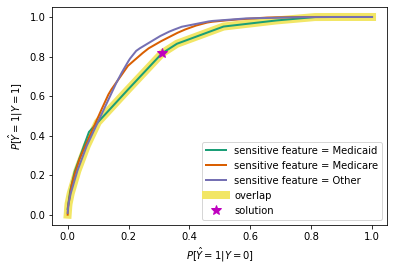

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,112,0.818182,0.366337,0.725923
Medicare,1057,0.9,0.302166,0.798917
Other,919,0.92638,0.267196,0.829592


0.7293722293722295

{'Medicaid': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4662180681094047],
  'operation1': [>0.4662180681094047]},
 'Medicare': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4627234990746489],
  'operation1': [>0.4627234990746489]},
 'Other': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4393429438769817],
  'operation1': [>0.4393429438769817]}}

In [12]:
mf_deterministic, eo_ratio_deterministic, fair_est_deterministic, fair_dict_deterministic, mf, eo_ratio, fair_est, fair_dict = fairness_fun(hold_out_data, train_data, test_data, 'insurance', "equalized_odds")
plot_threshold_optimizer(fair_est)
mf_deterministic
eo_ratio_deterministic
fair_dict_deterministic

The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the 

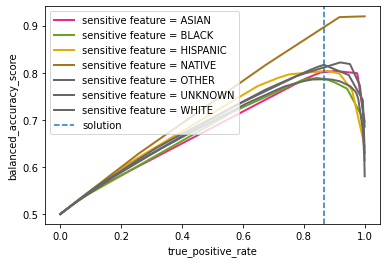

,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,63,0.923077,0.24,0.841538
BLACK,210,0.928571,0.252747,0.837912
HISPANIC,92,1.0,0.257143,0.871429
OTHER,79,0.692308,0.166667,0.762821
UNKNOWN,196,0.825,0.198718,0.813141
WHITE,1448,0.882353,0.281818,0.800267


0.5913978494623656

{'ASIAN': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5709261795133352],
  'operation1': [>0.5709261795133352]},
 'BLACK': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5459131303628286],
  'operation1': [>0.5459131303628286]},
 'HISPANIC': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.47539550900459293],
  'operation1': [>0.47539550900459293]},
 'NATIVE': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.6935303819974263],
  'operation1': [>0.6935303819974263]},
 'OTHER': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5300123551232474],
  'operation1': [>0.5300123551232474]},
 'UNKNOWN': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.607661520242691],
  'operation1': [>0.607661520242691]},
 'WHITE': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.48304877880215646],
  'operation1': [>0.48304877880215646]}}

In [536]:
mf_deterministic, eo_ratio_deterministic, fair_est_deterministic, fair_dict_deterministic, mf, eo_ratio, fair_est, fair_dict = fairness_fun(hold_out_data, train_data, test_data, 'grouped_race', "true_positive_rate_parity")
plot_threshold_optimizer(fair_est)
mf_deterministic
eo_ratio_deterministic
fair_dict_deterministic

In [501]:
mf

,count,true_positive_rate,false_negative_rate,AUROC
insurance,,,,
Medicaid,112,0.818182,0.366337,0.725923
Medicare,1057,0.822222,0.307868,0.757177
Other,919,0.815951,0.260582,0.777684


The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the 

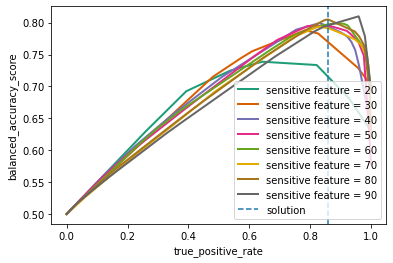

,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,22,1.0,0.45,0.775
30,52,0.75,0.229167,0.760417
40,89,0.5,0.188235,0.655882
50,274,0.857143,0.182222,0.83746
60,500,0.895349,0.243961,0.825694
70,549,0.887931,0.316397,0.785767
80,435,0.741935,0.190349,0.775793
90,167,1.0,0.338235,0.830882


0.4049382716049383

{'20': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.31346150950590773],
  'operation1': [>0.31346150950590773]},
 '30': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4663043142259122],
  'operation1': [>0.4663043142259122]},
 '40': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5707299564480781],
  'operation1': [>0.5707299564480781]},
 '50': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5556329654057821],
  'operation1': [>0.5556329654057821]},
 '60': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.5425275147837751],
  'operation1': [>0.5425275147837751]},
 '70': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.49297526013851173],
  'operation1': [>0.49297526013851173]},
 '80': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.6016742123663426],
  'operation1': [>0.6016742123663426]},
 '90': {'p0': 0.0,
  'p1': 1.0,
  'operation0': [>0.4198117341364132],
  'operation1': [>0.4198117341364132]}}

In [15]:
mf_deterministic, eo_ratio_deterministic, fair_est_deterministic, fair_dict_deterministic, mf, eo_ratio, fair_est, fair_dict = fairness_fun(hold_out_data, train_data, test_data, 'anchor_age', "true_positive_rate_parity")
plot_threshold_optimizer(fair_est)
mf_deterministic
eo_ratio_deterministic
fair_dict_deterministic

In [11]:
def native_fair_performance(model, data, test_data, string='insurance'):

  demographics = demographics_fun(data) 

  # Filter for string
  demographics = demographics[['stay_id', string]]

  # Change column to type string not object ...
  demographics[string] = pd.Series(demographics[string], dtype="string")

  # Get test data
  new_test_data = pd.merge(test_data, demographics)
  new_test_data.sort_values(by=[string], inplace=True)
  new_test_data_y = new_test_data['po_flag']
  new_test_data_sens = new_test_data[[string]]

  Y_pred_postprocess = []

  for x in new_test_data[string].unique():

    temp_data = new_test_data[new_test_data[string] == x].drop(columns=[string])

    # Define batch size 
    batch_size = 256

    temp_dataset = MIMICDataset(temp_data)
    temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=batch_size, collate_fn=temp_dataset.collate_fn_padd)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    temp_loss, temp_accuracy, temp_auroc, temp_predictions, temp_labels = evaluate(model, temp_dataloader, criterion)

    Y_pred_postprocess.extend(temp_predictions)
  
  Y_pred_postprocess, Y_pred_postprocess_ub = new_threshold_fun(Y_pred_postprocess)

  metrics_dict = {'count': count,"true_positive_rate": true_positive_rate,"false_positive_rate": false_positive_rate,'AUROC':roc_auc_score}
  
  mf = MetricFrame(metrics=metrics_dict,y_true=new_test_data_y,y_pred=Y_pred_postprocess,sensitive_features=new_test_data_sens).by_group
  
  return mf

In [531]:
model.load_state_dict(torch.load('optuna_switch_model_short.pt'))

<All keys matched successfully>

In [532]:
origional_mf = native_fair_performance(model, hold_out_data, test_data, 'grouped_race')

100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


In [533]:
origional_mf

,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,63,0.923077,0.26,0.831538
BLACK,210,0.928571,0.252747,0.837912
HISPANIC,92,1.0,0.257143,0.871429
OTHER,79,0.692308,0.151515,0.770396
UNKNOWN,196,0.9,0.224359,0.837821
WHITE,1448,0.861345,0.244628,0.808358


In [12]:
# Function to train and eval model 
def fair_run_fun(data_dict, model, string, data, constraint_x="equalized_odds"):

    # Define batch size 
    batch_size = 256

    # Define optimizer and learning_rate
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    # Define epochs and clip
    N_EPOCHS = 10 #10
    CLIP = 1

    origional_insurance_df = pd.DataFrame()
    origional_race_df = pd.DataFrame()
    origional_age_df = pd.DataFrame()
    fair_insurance_df = pd.DataFrame()
    fair_race_df = pd.DataFrame()
    fair_age_df = pd.DataFrame()
    fair_dict_deterministic_insurance_list = []
    fair_dict_deterministic_race_list = []
    fair_dict_deterministic_age_list = []

    # Iterate through dict i.e fold
    for key, value in data_dict.items():
        train_data2 = value[0] # smote
        valid_data = value[1]
        test_data = value[2]
        train_data = value[2] # no smote 

        # Initializing the weights of our model each fold
        model.apply(init_weights)
        
        # Define dataloaders
        train_dataset = MIMICDataset(train_data2)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)

        valid_dataset = MIMICDataset(valid_data)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

        test_dataset = MIMICDataset(test_data)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

        # Run
        best_valid_loss = float('inf')
        best_valid_auroc = 0

        for epoch in range(N_EPOCHS):

            start_time = time.time()

            train_loss, train_accuracy, train_auroc, train_predictions, train_labels = train(model, train_dataloader, optimizer, criterion, CLIP)
            valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                #print('BEST VALID LOSS')

            if valid_auroc > best_valid_auroc:
                best_valid_auroc = valid_auroc
                #print('UPDATED BEST INTERMEDIATE MODEL')
                torch.save(model.state_dict(), f'hold_out_switch_model_intermediate_{string}.pt')

        # -----------------------------
        # Evaluate best model on test set
        # -----------------------------

        model.load_state_dict(torch.load(f'hold_out_switch_model_intermediate_{string}.pt'))

        string_list= ['insurance', 'grouped_race', 'anchor_age']

        for fair_string in string_list:

            origional_mf = native_fair_performance(model, data, test_data, fair_string)

            mf_deterministic, eo_ratio_deterministic, fair_est_deterministic, fair_dict_deterministic, mf, eo_ratio, fair_est, fair_dict = fairness_fun(data, train_data, test_data, fair_string, constraint=constraint_x, cv=True)

            #print(origional_mf)
            #print(mf_deterministic)

            if fair_string == 'insurance':
                origional_insurance_df = pd.concat((origional_insurance_df, origional_mf))
                fair_insurance_df = pd.concat((fair_insurance_df, mf_deterministic))
                fair_dict_deterministic_insurance_list.append(fair_dict_deterministic)
            elif fair_string == 'grouped_race':
                origional_race_df = pd.concat((origional_race_df, origional_mf))
                fair_race_df = pd.concat((fair_race_df, mf_deterministic))
                fair_dict_deterministic_race_list.append(fair_dict_deterministic)
            elif fair_string == 'anchor_age':
                origional_age_df = pd.concat((origional_age_df, origional_mf))
                fair_age_df = pd.concat((fair_age_df, mf_deterministic))
                fair_dict_deterministic_age_list.append(fair_dict_deterministic)

    # Get mean
    by_row_index = origional_insurance_df.groupby(origional_insurance_df.index)
    origional_insurance_df = by_row_index.mean()
    by_row_index = fair_insurance_df.groupby(fair_insurance_df.index)
    fair_insurance_df = by_row_index.mean()
    by_row_index = origional_race_df.groupby(origional_race_df.index)
    origional_race_df = by_row_index.mean()
    by_row_index = fair_race_df.groupby(fair_race_df.index)
    fair_race_df = by_row_index.mean()
    by_row_index = origional_age_df.groupby(origional_age_df.index)
    origional_age_df = by_row_index.mean()
    by_row_index = fair_age_df.groupby(fair_age_df.index)
    fair_age_df = by_row_index.mean()


    return origional_insurance_df, fair_insurance_df, fair_dict_deterministic_insurance_list, origional_race_df, fair_race_df, fair_dict_deterministic_race_list, origional_age_df, fair_age_df, fair_dict_deterministic_age_list

In [13]:
# Function to split data so even distribution between val and test
def fair_data_fun(data, individual, n_cv=10):

    demographics = demographics_fun(data)
    
    data_dict = {}
    random_x_list = []
    x = -1

    for i in range(n_cv):
        x += 1
        #if x == 25 or x == 33:
        #    x += 1
        #print('x', x)
        stays = data['stay_id'].unique()
        random.Random(x).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
        #random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

        X_data = data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
        # Filter for features in this individual
        X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
        model_data = pd.concat([data[['stay_id', 'po_flag']], X_data], axis=1)
        model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
        n = round(0.7 * len(stays))
        n2 = round(0.85 * len(stays))
        train_stays = stays[:n]
        validation_stays = stays[n:n2]
        test_stays = stays[n2:]
        train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
        valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
        test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
        train_data2 = smote_fun(train_data)

        # Filter for fair labels
        while not (pd.merge(test_data, demographics).groupby('insurance').po_flag.nunique() > 1).all() & (pd.merge(test_data, demographics).groupby('grouped_race').po_flag.nunique() > 1).all() & (pd.merge(test_data, demographics).groupby('anchor_age').po_flag.nunique() > 1).all():
            x +=1
            #if x == 25 or x == 33:
            #    x += 1
            #print('x', x)
            stays = data['stay_id'].unique()
            random.Random(x).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
            #random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

            X_data = data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
            # Filter for features in this individual
            X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
            model_data = pd.concat([data[['stay_id', 'po_flag']], X_data], axis=1)
            model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
            n = round(0.7 * len(stays))
            n2 = round(0.85 * len(stays))
            train_stays = stays[:n]
            validation_stays = stays[n:n2]
            test_stays = stays[n2:]
            train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
            valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
            test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
            train_data2 = smote_fun(train_data)
 
        #print(type(test_data.po_flag.value_counts(normalize=True)[1]))
        #print(type(valid_data.po_flag.value_counts(normalize=True)[1]))
        #print(test_data.po_flag.value_counts(normalize=True)[1])
        #print(valid_data.po_flag.value_counts(normalize=True)[1])
        #print(math.isclose(test_data.po_flag.value_counts(normalize=True)[1], valid_data.po_flag.value_counts(normalize=True)[1], abs_tol=0.005))
        #print(abs(test_data.po_flag.value_counts(normalize=True)[1] - valid_data.po_flag.value_counts(normalize=True)[1]) <= 0.5)

        while not math.isclose(test_data.po_flag.value_counts(normalize=True)[1], valid_data.po_flag.value_counts(normalize=True)[1], abs_tol=0.005): # Check to make sure val and test set are comparable
            x +=1
            #if x == 25 or x == 33:
            #    x += 1
            #print('x', x)
            stays = data['stay_id'].unique()
            random.Random(x).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
            #random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

            X_data = data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
            # Filter for features in this individual
            X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
            model_data = pd.concat([data[['stay_id', 'po_flag']], X_data], axis=1)
            model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
            n = round(0.7 * len(stays))
            n2 = round(0.85 * len(stays))
            train_stays = stays[:n]
            validation_stays = stays[n:n2]
            test_stays = stays[n2:]
            train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
            valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
            test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
            train_data2 = smote_fun(train_data)

            # Filter for fair labels
            while not (pd.merge(test_data, demographics).groupby('insurance').po_flag.nunique() > 1).all() & (pd.merge(test_data, demographics).groupby('grouped_race').po_flag.nunique() > 1).all() & (pd.merge(test_data, demographics).groupby('anchor_age').po_flag.nunique() > 1).all():
                x +=1
                #if x == 25 or x == 33:
                #    x += 1
                #print('x', x)
                stays = data['stay_id'].unique()
                random.Random(x).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
                #random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

                X_data = data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
                # Filter for features in this individual
                X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
                model_data = pd.concat([data[['stay_id', 'po_flag']], X_data], axis=1)
                model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
                n = round(0.7 * len(stays))
                n2 = round(0.85 * len(stays))
                train_stays = stays[:n]
                validation_stays = stays[n:n2]
                test_stays = stays[n2:]
                train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
                valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
                test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
                train_data2 = smote_fun(train_data)

            #print(test_data.po_flag.value_counts(normalize=True)[1])
            #print(valid_data.po_flag.value_counts(normalize=True)[1])
            #print(math.isclose(test_data.po_flag.value_counts(normalize=True)[1], valid_data.po_flag.value_counts(normalize=True)[1], abs_tol=0.005))
        
        data_dict[i] = [train_data2, valid_data, test_data, train_data]
        random_x_list.append(x)

    return data_dict, random_x_list

In [23]:
# TEST # 

# Get data from best run in cv - note no smote on train data 
stays = hold_out_data['stay_id'].unique()
random.Random(25).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

demographics = demographics_fun(hold_out_data) 

# Filter for string
string = 'insurance'
demographics = demographics[['stay_id', string]]

# Change column to type string not object ...
demographics[string] = pd.Series(demographics[string], dtype="string")

# Get test data
new_test_data = pd.merge(test_data, demographics)
new_test_data.sort_values(by=[string], inplace=True)
new_test_data_y = new_test_data['po_flag']
new_test_data_sens = new_test_data[[string]]

Y_pred_postprocess = []

for x in new_test_data[string].unique():

    model.load_state_dict(torch.load('hold_out_switch_model_short.pt'))

    temp_data = new_test_data[new_test_data[string] == x].drop(columns=[string])

    # Define batch size 
    batch_size = 256

    temp_dataset = MIMICDataset(temp_data)
    temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=batch_size, collate_fn=temp_dataset.collate_fn_padd)

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    temp_loss, temp_accuracy, temp_auroc, temp_predictions, temp_labels = evaluate(model, temp_dataloader, criterion)

    temp_predictions, Y_pred_postprocess_ub = new_threshold_fun(temp_predictions)

    Y_pred_postprocess.extend(temp_predictions)

    print(x, roc_auc_score(temp_labels, temp_predictions))
    cm = confusion_matrix(temp_labels, temp_predictions)
    tn, fp, fn, tp = confusion_matrix(temp_labels, temp_predictions).ravel()
    print('tn', tn)
    print('fp', fp)
    print('fn', fn)
    print('tp', tp)
    tp, fp, tn, fn = perf_measure(temp_labels, temp_predictions)
    print('tn', tn)
    print('fp', fp)
    print('fn', fn)
    print('tp', tp)
    print((cm[0][0]) / (cm[0][0] + cm[0][1]))
    print((cm[1][0]) / (cm[1][0] + cm[1][1]))

#Y_pred_postprocess, Y_pred_postprocess_ub = new_threshold_fun(Y_pred_postprocess)

metrics_dict = {'count': count,"true_positive_rate": true_positive_rate,"false_positive_rate": false_positive_rate,'AUROC':roc_auc_score}

mf = MetricFrame(metrics=metrics_dict,y_true=new_test_data_y,y_pred=Y_pred_postprocess,sensitive_features=new_test_data_sens).by_group

equalised_odds_df = equalised_odds(test_data, batch_size, model, criterion)

mf
equalised_odds_df

<All keys matched successfully>

100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

Medicaid 0.735823582358236
tn 66
fp 35
fn 2
tp 9
tn 66
fp 35
fn 2
tp 9
0.6534653465346535
0.18181818181818182


<All keys matched successfully>

100%|██████████| 5/5 [00:00<00:00,  5.46it/s]

Medicare 0.8059039655390854
tn 634
fp 243
fn 20
tp 160
tn 634
fp 243
fn 20
tp 160
0.7229190421892816
0.1111111111111111


<All keys matched successfully>

100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Other 0.8178579543610218
tn 578
fp 178
fn 21
tp 142
tn 578
fp 178
fn 21
tp 142
0.7645502645502645
0.12883435582822086


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,112,0.818182,0.346535,0.735824
Medicare,1057,0.888889,0.277081,0.805904
Other,919,0.871166,0.23545,0.817858


,column,value,accuracy,auroc,cm,true_positive_rate,false_positive_rate
0,gender,F,0.797072,0.797072,"[[559, 209], [23, 149]]",0.866279,0.272135
1,gender,M,0.817208,0.817208,"[[719, 247], [20, 162]]",0.890110,0.255694
2,anchor_age,20,0.850000,0.850000,"[[14, 6], [0, 2]]",1.000000,0.300000
3,anchor_age,30,0.770833,0.770833,"[[38, 10], [1, 3]]",0.750000,0.208333
4,anchor_age,40,0.655882,0.655882,"[[69, 16], [2, 2]]",0.500000,0.188235
5,anchor_age,50,0.819683,0.819683,"[[176, 49], [7, 42]]",0.857143,0.217778
6,anchor_age,60,0.820638,0.820638,"[[304, 110], [8, 78]]",0.906977,0.265700
7,anchor_age,70,0.781765,0.781765,"[[300, 133], [15, 101]]",0.870690,0.307159
8,anchor_age,80,0.809457,0.809457,"[[285, 88], [9, 53]]",0.854839,0.235925
9,anchor_age,90,0.822106,0.822106,"[[92, 44], [1, 30]]",0.967742,0.323529


In [14]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

In [47]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)

#all_shap_importance = pd.read_csv('VSCode_projects/stop/csv/all_shap_importance.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

In [48]:
fair_data_dict, fair_random_x_list = fair_data_fun(hold_out_data, individual, n_cv=10)

In [50]:
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

# Initializing the weights of our model.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Calculate the number of trainable parameters in the model.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

The model has 11,307 trainable parameters


In [19]:
# Run fair short model cv - true_positive_rate_parity
origional_insurance_df3, fair_insurance_df3, fair_insurance_dict_list3, origional_race_df3, fair_race_df3, fair_race_dict_list3, origional_age_df3, fair_age_df3, fair_age_dict_list3 = fair_run_fun(fair_data_dict, model, 'short', hold_out_data, constraint_x="true_positive_rate_parity")

100%|██████████| 4/4 [00:00<00:00,  4.51it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [20]:
origional_insurance_df3
fair_insurance_df3
origional_race_df3
fair_race_df3
origional_age_df3
fair_age_df3

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.673500,0.274701,0.699399
Medicare,1090.6,0.832523,0.268752,0.781885
Other,923.8,0.843254,0.259375,0.791940


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.815142,0.388606,0.713268
Medicare,1090.6,0.863766,0.295368,0.784199
Other,923.8,0.867680,0.263446,0.802117


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.834060,0.289615,0.772222
BLACK,223.600000,0.820041,0.266798,0.776621
HISPANIC,76.400000,0.852318,0.248376,0.801971
NATIVE,11.285714,0.928571,0.259694,0.834439
OTHER,73.500000,0.746434,0.229864,0.758285
UNKNOWN,219.100000,0.889511,0.261421,0.814045
WHITE,1486.300000,0.822164,0.267197,0.777483


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.807017,0.378335,0.714341
BLACK,223.600000,0.860630,0.280720,0.789955
HISPANIC,76.400000,0.835987,0.307729,0.764129
NATIVE,11.285714,0.928571,0.428571,0.750000
OTHER,73.500000,0.844942,0.285246,0.779848
UNKNOWN,219.100000,0.858905,0.229244,0.814831
WHITE,1486.300000,0.868743,0.306911,0.780916


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.747619,0.299045,0.724287
30,54.8,0.864881,0.249272,0.807804
40,114.7,0.758307,0.253249,0.752529
50,266.8,0.868950,0.270293,0.799329
60,544.3,0.827936,0.253918,0.787009
70,483.0,0.812339,0.266492,0.772923
80,483.8,0.860102,0.274080,0.793011
90,173.1,0.770251,0.267752,0.751250


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.858730,0.608057,0.625336
30,54.8,0.729048,0.279441,0.724803
40,114.7,0.820332,0.308861,0.755736
50,266.8,0.856952,0.246921,0.805016
60,544.3,0.868137,0.294951,0.786593
70,483.0,0.869930,0.307924,0.781003
80,483.8,0.865686,0.264738,0.800474
90,173.1,0.858297,0.301637,0.778330


In [51]:
# Run fair short model cv - false_positive_rate_parity
origional_insurance_df2, fair_insurance_df2, fair_insurance_dict_list2, origional_race_df2, fair_race_df2, fair_race_dict_list2, origional_age_df2, fair_age_df2, fair_age_dict_list2 = fair_run_fun(fair_data_dict, model, 'short', hold_out_data, constraint_x="false_positive_rate_parity")

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [28]:
origional_insurance_df2
fair_insurance_df2
origional_race_df2
fair_race_df2
origional_age_df2
fair_age_df2

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.662944,0.272503,0.695221
Medicare,1090.6,0.832098,0.269010,0.781544
Other,923.8,0.840814,0.262163,0.789325


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.699409,0.294664,0.702373
Medicare,1090.6,0.848907,0.275882,0.786512
Other,923.8,0.872216,0.274398,0.798909


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.813974,0.299608,0.757183
BLACK,223.600000,0.817638,0.263749,0.776944
HISPANIC,76.400000,0.872520,0.247770,0.812375
NATIVE,11.285714,0.976190,0.312415,0.831888
OTHER,73.500000,0.738031,0.228017,0.755007
UNKNOWN,219.100000,0.887932,0.263510,0.812211
WHITE,1486.300000,0.818812,0.268474,0.775169


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.803684,0.306312,0.748686
BLACK,223.600000,0.863341,0.280257,0.791542
HISPANIC,76.400000,0.894742,0.271086,0.811828
NATIVE,11.285714,1.000000,0.791837,0.604082
OTHER,73.500000,0.834368,0.287860,0.773254
UNKNOWN,219.100000,0.910545,0.280919,0.814813
WHITE,1486.300000,0.839652,0.274949,0.782352


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.736508,0.311382,0.712563
30,54.8,0.849881,0.264780,0.792551
40,114.7,0.770256,0.252416,0.758920
50,266.8,0.861388,0.267866,0.796761
60,544.3,0.820408,0.258076,0.781166
70,483.0,0.806812,0.262816,0.771998
80,483.8,0.859221,0.276283,0.791469
90,173.1,0.793522,0.272574,0.760474


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.692063,0.376234,0.657915
30,54.8,0.837381,0.356412,0.740485
40,114.7,0.807760,0.287035,0.760363
50,266.8,0.872863,0.282924,0.794969
60,544.3,0.845908,0.280555,0.782677
70,483.0,0.846834,0.279099,0.783867
80,483.8,0.888083,0.279981,0.804051
90,173.1,0.817870,0.284597,0.766636


In [33]:
# Run fair short model cv - equalized_odds
origional_insurance_df, fair_insurance_df, fair_insurance_dict_list, origional_race_df, fair_race_df, fair_race_dict_list, origional_age_df, fair_age_df, fair_age_dict_list = fair_run_fun(fair_data_dict, model, 'short', hold_out_data, constraint_x="equalized_odds")

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing InterpolatedThresholder has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base 

In [34]:
origional_insurance_df
fair_insurance_df
origional_race_df
fair_race_df
origional_age_df
fair_age_df

,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.675166,0.272702,0.701232
Medicare,1090.6,0.839069,0.266091,0.786489
Other,923.8,0.846769,0.257686,0.794542


,count,true_positive_rate,false_positive_rate,AUROC
insurance,,,,
Medicaid,137.8,0.824385,0.341402,0.741492
Medicare,1090.6,0.878658,0.330566,0.774046
Other,923.8,0.904094,0.332563,0.785766


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.865363,0.292263,0.786550
BLACK,223.600000,0.834323,0.262625,0.785849
HISPANIC,76.400000,0.861409,0.240307,0.810551
NATIVE,11.285714,0.976190,0.277551,0.849320
OTHER,73.500000,0.736221,0.235162,0.750529
UNKNOWN,219.100000,0.898028,0.255856,0.821086
WHITE,1486.300000,0.822657,0.265423,0.778617


,count,true_positive_rate,false_positive_rate,AUROC
grouped_race,,,,
ASIAN,65.400000,0.848697,0.461583,0.693557
BLACK,223.600000,0.878473,0.310015,0.784229
HISPANIC,76.400000,0.908492,0.646076,0.631208
NATIVE,11.285714,1.000000,1.000000,0.500000
OTHER,73.500000,0.858037,0.502932,0.677552
UNKNOWN,219.100000,0.925400,0.377844,0.773778
WHITE,1486.300000,0.864441,0.307432,0.778505


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.747619,0.295218,0.726200
30,54.8,0.852381,0.249607,0.801387
40,114.7,0.786487,0.250182,0.768152
50,266.8,0.857239,0.264358,0.796441
60,544.3,0.831122,0.255031,0.788045
70,483.0,0.813672,0.264180,0.774746
80,483.8,0.863722,0.271547,0.796088
90,173.1,0.796494,0.263915,0.766290


,count,true_positive_rate,false_positive_rate,AUROC
anchor_age,,,,
20,31.7,0.869841,0.672102,0.598870
30,54.8,0.904167,0.714790,0.594688
40,114.7,0.849523,0.372848,0.738338
50,266.8,0.880073,0.375583,0.752245
60,544.3,0.883536,0.318252,0.782642
70,483.0,0.852018,0.315258,0.768380
80,483.8,0.887227,0.316828,0.785199
90,173.1,0.865828,0.384233,0.740798


In [55]:
# Save 
'''with open("short_eo_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df, fp)
with open("short_eo_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df, fp)
with open("short_eo_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df, fp)
with open("short_eo_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df, fp)
with open("short_eo_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df, fp)
with open("short_eo_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df, fp)

with open("short_fpr_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df2, fp)
with open("short_fpr_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df2, fp)
with open("short_fpr_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df2, fp)
with open("short_fpr_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df2, fp)
with open("short_fpr_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df2, fp)
with open("short_fpr_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df2, fp)

with open("short_tpr_origional_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(origional_insurance_df3, fp)
with open("short_tpr_fair_insurance_results", "wb") as fp:   #Pickling
    pickle.dump(fair_insurance_df3, fp)
with open("short_tpr_origional_race_results", "wb") as fp:   #Pickling
    pickle.dump(origional_race_df3, fp)
with open("short_tpr_fair_race_results", "wb") as fp:   #Pickling
    pickle.dump(fair_race_df3, fp)
with open("short_tpr_origional_age_results", "wb") as fp:   #Pickling
    pickle.dump(origional_age_df3, fp)
with open("short_tpr_fair_age_results", "wb") as fp:   #Pickling
    pickle.dump(fair_age_df3, fp)'''
    